# S&P 500(DUK) 종가 시계열 예측

- 데이터 출처 : [kaggle_S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)
- 통상 주가 예측은 주가를 로그리턴으로 만든 후 분석하지만 다음 분석은 일반적인 시계열 데이터와 같은 방식으로 시행하겠다.
- 참고: [garch_python](https://arch.readthedocs.io/en/latest/univariate/introduction.html)

# 1. 데이터 탐색

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# acf, pacf plot
import statsmodels.graphics.tsaplots as sgt 

# !pip install pmdarima
import pmdarima # auto.arima
# !pip install arch
from arch import arch_model

In [188]:
data = pd.read_csv("./data/all_stocks_5yr.csv")
data['date'] = pd.to_datetime(data['date'])

In [189]:
print(data.head(3)) 
print(data.tail(3))
print(data.info())
print(data.describe())

        date   open   high    low  close   volume Name
0 2013-02-08  15.07  15.12  14.63  14.75  8407500  AAL
1 2013-02-11  14.89  15.01  14.26  14.46  8882000  AAL
2 2013-02-12  14.45  14.51  14.10  14.27  8126000  AAL
             date   open   high    low  close   volume Name
619037 2018-02-05  76.64  76.92  73.18  73.83  2962031  ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27  4924323  ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86  4534912  ZTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1)

종목별 시계열 그림을 그려본다. 다음 종목 중 DUK를 분석하겠다.

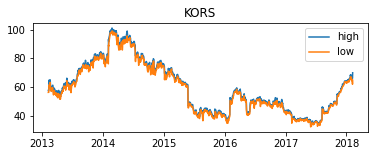

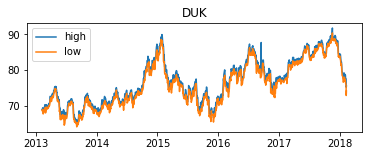

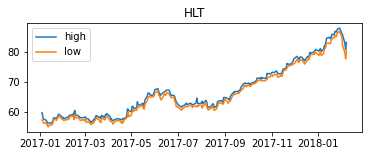

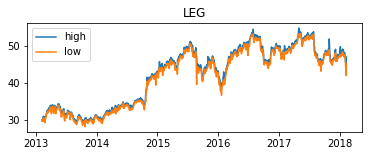

In [190]:
# 종목 랜덤 추출
import random
random.seed(2022)
stock_name = random.sample(data['Name'].unique().tolist(), 4)

# 종목별 상한가, 하한가 시계열 그림
for name in stock_name:
  plt.figure(figsize=(6,2))
  for label in ['high','low']:
    plt.plot(data.loc[data['Name'] == name,'date'],
            data.loc[data['Name'] == name,label], label=label)
    plt.legend()
  plt.title(name)
  plt.show()

# 2. 통계학 버전 분석

## 2.1. 데이터 전체, 원계열

In [191]:
item = data[data['Name']=='DUK'].reset_index(drop=True)

ACF가 매우 천천히 내려감 -> 비정상 계열이라는 증거

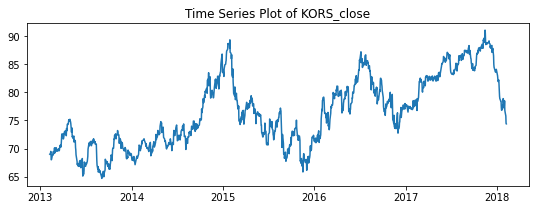

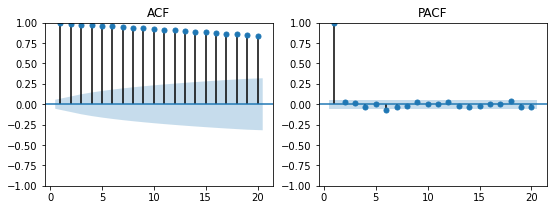

In [234]:
fig = plt.figure(figsize=(9,3))
plt.plot(item['date'], item['close'])
plt.title('Time Series Plot of KORS_close')
plt.show()

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sgt.plot_acf(item['close'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")

sgt.plot_pacf(item['close'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")

plt.show()

## 2.2. 데이터 전체, 차분계열

- 1차 차분 후 정상성이 보임
- 시간 구간 별로 값의 변동성이 다름(volatility clustering), 2015 ~ 2016년의 값의 변동폭이 커보임

In [193]:
item['close_diff']=item['close'].diff(periods =1) # 1차 차분, 행 기준

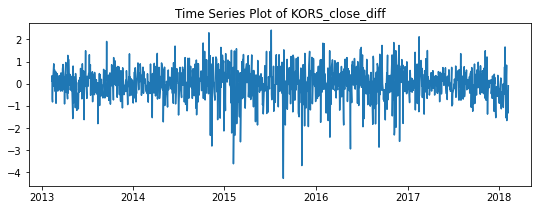

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


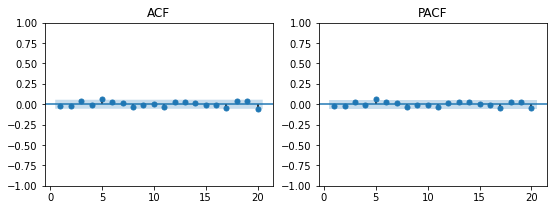

In [194]:
fig = plt.figure(figsize=(9,3))
plt.plot(item['date'], item['close_diff'])
plt.title('Time Series Plot of KORS_close_diff')
plt.show()

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sgt.plot_acf(item['close_diff'][1:], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")

sgt.plot_pacf(item['close_diff'][1:], lags = 20, zero = False, ax=ax2)
ax2.set_title("PACF")

plt.show()

## 2.3. 데이터 일부 추출, 데이터 분할

- 2016년 4월 14일 - 2017년 4월 10일 추출
- 시간 구간에 따라 랜덤워크가 최적 모형인 경우 미래시점 예측이 불가능함 
<br/> -> ARMA의 차수 p,q가 0이 아닌 시간 구간을 추출해 시계열 예측 시행

In [195]:
sample_start = 850
sample_end = 1200
sample_test = 20

train = item['close'][sample_start:sample_end]
test = item['close'][sample_end:(sample_end + sample_test)]

- 데이터 원계열과 차분 계열 비교
- 1차 차분 후 정상 시계열 데이터가 됨

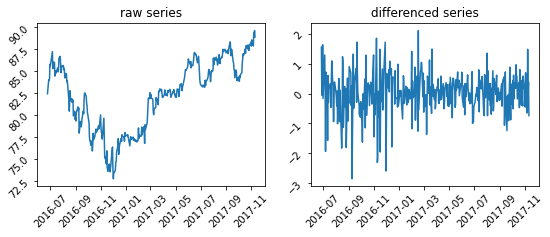

In [196]:
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(item['date'][sample_start:sample_end], train)
ax1.set_title("raw series")
ax1.tick_params(labelrotation=45)

ax2.plot(item['date'][(sample_start+1):sample_end], np.diff(train))
ax2.set_title("differenced series")
ax2.tick_params(labelrotation=45)
plt.show()

## 2.4. 모형적합1. ARIMA

In [227]:
arima = pmdarima.auto_arima(y=train,
                            #  X = x_train -- 외생변수, 예를들면 거래량(volume)
                            d=1, # 차분 차수 -- 위에서 비정상 데이터임을 확인
                            start_p = 1, # AR 차수 탐색 범위 0~5
                            max_p = 5,
                            start_q=1, # MA 차수 탐색 범위 0~5
                            max_q = 5,
                            m=1, # 계절성 차수, 1이면 계절성 없음
                            seasonal=False, 
                            stepwise = False, # 최적 차수 찾는 알고리즘
                            trace=True)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=749.047, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=747.294, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=748.878, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=750.404, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=751.835, Time=0.39 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=752.354, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=747.629, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=749.054, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=751.292, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=751.838, Time=1.00 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=751.597, Time=1.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=748.687, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=747.637, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=752.891, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=751.358, Time=1.08 sec
 ARIMA(3,1,0)(0,0,0)[0] i

### 2.4.1. 모형진단

모형적합 후 남은 잔차항이 등분산인 정규분포를 따라야 하며 시차가 다른 잔차 간 독립이어야 함
$$ y_t = \mu +a_t $$
$$ a_t \sim N(0, \sigma^2) $$

- Ljung Box test
  - H0: 잔차가 백색 잡음
- Heteroskedascity
  - H0: 잔차의 변동성이 등분산
  - 등분산이 아니면 GARCH 적합
- Jaque-Bera
  - H0: 잔차는 정규분포
- skew 0이어야 대칭
- kurtosis 3이어야 정규분포의 첨도

In [228]:
print(arima.summary())
# Ljung-Box, 백색잡음: H0 기각하지 않음
# Heteroskedasticity 등분산성: 기각 -> 이분산성 GARCH 필요
# Jarque-Bera 정규분포: 기각
# skew, kurtosis: 정규분포와 다름

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  350
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -370.647
Date:                Sun, 27 Feb 2022   AIC                            747.294
Time:                        12:43:45   BIC                            758.859
Sample:                             0   HQIC                           751.898
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0182      0.035      0.521      0.602      -0.050       0.087
ma.L1         -0.1087      0.043     -2.555      0.011      -0.192      -0.025
sigma2         0.4897      0.028     17.272      0.0

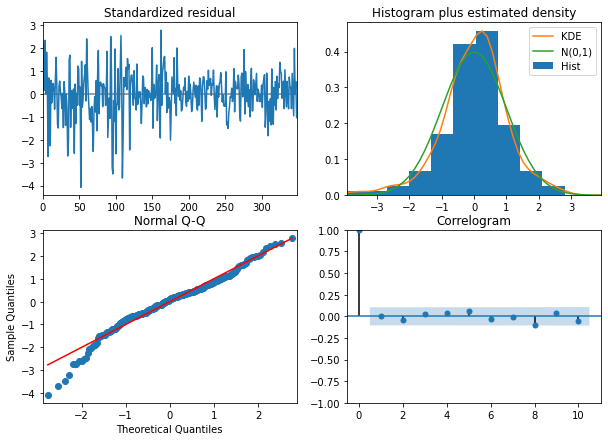

In [229]:
arima.plot_diagnostics(figsize=(10,7))
plt.show()
# 잔차가 등분산인가, 정규성을 만족하는가, 잔차 간 연관이 있는가

## 2.5. 모형적합2. GARCH

In [230]:
# p, d, q = arima.order
# arima 모델로부터 잔차 추출
arima_resid = arima.arima_res_.resid

# garch 적합
garch = arch_model(arima_resid, q=1) # p,q
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 559.3093691424313
Iteration:      2,   Func. Count:     15,   Neg. LLF: 549.2976928717069
Iteration:      3,   Func. Count:     22,   Neg. LLF: 486.2440222834518
Iteration:      4,   Func. Count:     29,   Neg. LLF: 467.12035693631805
Iteration:      5,   Func. Count:     36,   Neg. LLF: 447.8502808848936
Iteration:      6,   Func. Count:     43,   Neg. LLF: 433.34114051372205
Iteration:      7,   Func. Count:     50,   Neg. LLF: 421.49254486263425
Iteration:      8,   Func. Count:     57,   Neg. LLF: 412.4096299170309
Iteration:      9,   Func. Count:     64,   Neg. LLF: 405.620392475881
Iteration:     10,   Func. Count:     71,   Neg. LLF: 401.03410119369937
Iteration:     11,   Func. Count:     78,   Neg. LLF: 398.2736960324884
Iteration:     12,   Func. Count:     85,   Neg. LLF: 394.63955952508627
Iteration:     13,   Func. Count:     92,   Neg. LLF: 393.4317507049797
Iteration:     14,   Func. Count:     99,   Neg. LLF: 387.91

### 2.5.2. 모형진단

In [231]:
garch_fitted
# 계수(alpha) 유의; p-value<0.05

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -385.829
Distribution:                  Normal   AIC:                           779.658
Method:            Maximum Likelihood   BIC:                           795.090
                                        No. Observations:                  350
Date:                Sun, Feb 27 2022   Df Residuals:                      349
Time:                        12:43:46   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.2560e-03  3.528e-02  9.229e-02      0.926 

## 2.6. 예측

In [232]:
# Use ARIMA to predict mu
predicted_mu = arima.predict(n_periods=len(test))

# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=len(test))
predicted_et = garch_forecast.mean.iloc[-1,:]

# Combine both models' output: yt = mu + et
prediction = predicted_mu+np.array(predicted_et.tolist())

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


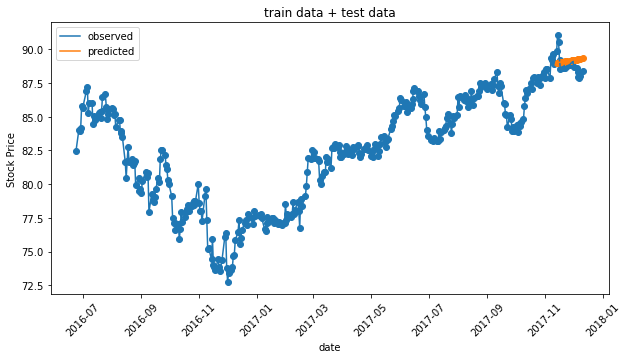

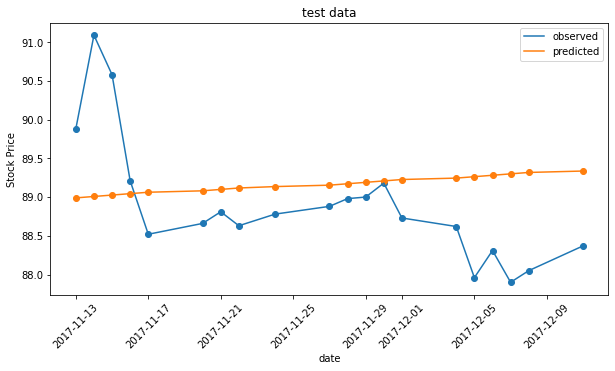

In [233]:
full_date = item['date'][sample_start:(sample_end + sample_test)]
test_date = item['date'][sample_end:(sample_end + sample_test)]
full_price = item['close'][sample_start:(sample_end + sample_test)]

plt.figure(figsize=(10,5))
plt.plot(full_date, full_price, label="observed")
plt.scatter(full_date, full_price)
plt.plot(test_date, prediction, label="predicted")
plt.scatter(test_date, prediction)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("train data + test data")
plt.show()


plt.figure(figsize=(10,5))
plt.plot(test_date, test, label="observed")
plt.scatter(test_date, test)
plt.plot(test_date, prediction, label="predicted")
plt.scatter(test_date, prediction)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.title("test data")
plt.legend()
plt.show()

# 3. 딥러닝 버전 분석

RNN을 이용하여 간단한 시계열 예측을 시도했다.

In [279]:
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 3.1. 데이터 분할 및 표준화

In [236]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i + look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [288]:
sample_start = 0 # 통계학 버전과 train size를 달리함
sample_end = 1200
sample_test = 20 # 예측 시점은 통계학 버전과 동일

item_tmp = item['close'][sample_start:(sample_end + sample_test)]
item_tmp = np.array(item_tmp).reshape((len(item_tmp),1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(item_tmp)

# look back 시점 5로 설정
dataX, dataY = create_dataset(scaler.transform(item_tmp).reshape(len(item_tmp)), 5)

In [289]:
dataY = dataY.reshape((len(dataY),1))

train_nn = sample_end - sample_start
trainX = dataX[:train_nn]
testX = dataX[train_nn:]

trainY = dataY[:train_nn]
testY = dataY[train_nn:]

print('-------- feature --------')
print(trainX[:3])
print('shape', trainX.shape)
print('-------- target --------')
print(trainY[:3])
print('shape', trainY.shape)

-------- feature --------
[[0.16325758 0.16856061 0.18219697 0.15643939 0.12537879]
 [0.16856061 0.18219697 0.15643939 0.12537879 0.12765152]
 [0.18219697 0.15643939 0.12537879 0.12765152 0.16174242]]
shape (1200, 5)
-------- target --------
[[0.12765152]
 [0.16174242]
 [0.15757576]]
shape (1200, 1)


## 3.2. 모델링 및 학습

In [291]:
keras.backend.clear_session()

model1 = Sequential()
model1.add(SimpleRNN(8, 
                return_sequences=True, 
                input_shape = (trainX.shape[1],1)))
model1.add(SimpleRNN(8, return_sequences=True)) 
model1.add(SimpleRNN(8))
model1.add(Dense(units = 1))
model1.compile(optimizer = 'adam', loss = 'mean_squared_error') 

In [292]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5, 8)              136       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [293]:
es = EarlyStopping(monitor ='val_loss', # loss를 관찰. val_loss,...
                  min_delta=0, # 개선되었음의 최소 요구량
                  patience=30, # 개선되지 않음을 몇번이나 연속으로 안내해줄 것인가
                  verbose=1, # 얼리스토핑이 되었을 때, 얼리스토핑이 되었음을 알려줌
                  restore_best_weights=True) # 얼리스토핑 후 가장 좋았던 시점의 가중치 반환

history = model1.fit(trainX, trainY, 
                     validation_data = (testX, testY),
                     epochs = 600, batch_size = 32, verbose = 0, callbacks=[es])

Restoring model weights from the end of the best epoch: 189.
Epoch 219: early stopping


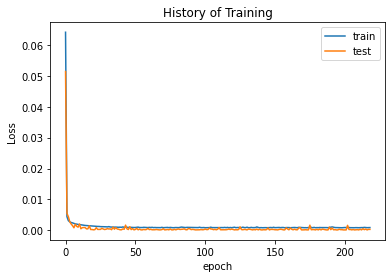

In [297]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.title("History of Training")
plt.show()

## 3.2. 예측결과

In [308]:
# 0~1 사이의 스케일을 원래 스케일로 바꾼 후 reshape
prediction = model1.predict(testX)
prediction = scaler.inverse_transform(prediction).reshape(len(prediction))

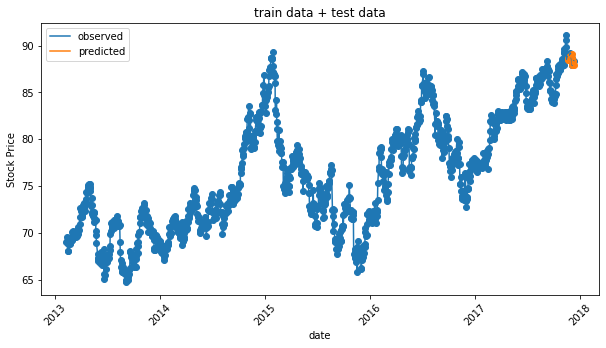

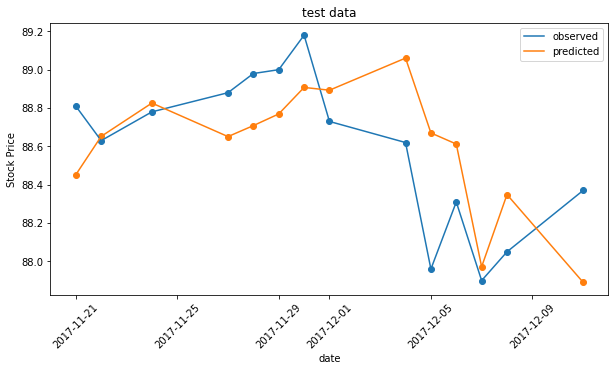

In [314]:
look_back = 5
full_date = item['date'][sample_start:(sample_end + sample_test)]
test_date = item['date'][(sample_end + look_back + 1):(sample_end + sample_test)]
test =  item['close'][(sample_end + look_back + 1):(sample_end + sample_test)]
full_price = item['close'][sample_start:(sample_end + sample_test)]

plt.figure(figsize=(10,5))
plt.plot(full_date, full_price, label="observed")
plt.scatter(full_date, full_price)
plt.plot(test_date, prediction, label="predicted")
plt.scatter(test_date, prediction)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("train data + test data")
plt.show()


plt.figure(figsize=(10,5))
plt.plot(test_date, test, label="observed")
plt.scatter(test_date, test)
plt.plot(test_date, prediction, label="predicted")
plt.scatter(test_date, prediction)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.title("test data")
plt.legend()
plt.show()

통계학 버전 분석과 공정한 비교를 하려면, test 시점의 데이터는 없다고 가정하고, 2017년 11월 21일 이후 예측을 위한 input은 앞시점의 예측값을 축차적으로 포함하여 만든다.
- [11/18 관측값, 11/19 관측값, 11/20 관측값, 11/21 관측값, 11/22 예측값] -> 11/23 예측값 발생
- [11/19 관측값, 11/20 관측값, 11/21 관측값, 11/22 예측값, 11/23 예측값] -> 11/24 예측값 발생
- [11/20 관측값, 11/21 관측값, 11/22 예측값, 11/23 예측값, 11/24 예측값] -> 11/25 예측값 발생
- ...

바로 위 관측값을 input으로 예측했을 때보다는 성능이 떨어지지만 통계학 버전의 예측보다는 성능이 좋다.

In [373]:
prediction_list = []

prediction = model1.predict(testX[0,:].reshape((1,5)))
prediction_list.append(prediction[0][0])

for i in range(1,5):
  # iteration 1: 1~4 timestamp는 관측치, 5는 예측치
  # iteration 2: 1~3 timestamp는 관측치, 4~5는 예측치
  # iteration 3: 1~2 timestamp는 관측치, 3~5는 예측치
  # ...
  XX = np.append(testX[0,i:], np.array(prediction_list)) 
  prediction = model1.predict(XX.reshape((1,5)))
  prediction_list.append(prediction[0][0])


for i in range(len(testX)-look_back):
  # 최신 5개 값으로 다음 값 예측
  prediction = model1.predict(np.array(prediction_list[-5:]).reshape((1,5)))
  prediction_list.append(prediction[0][0])

In [383]:
# 원래 스케일로 반환
prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape((len(prediction_list),1))).\
reshape(len(prediction_list))

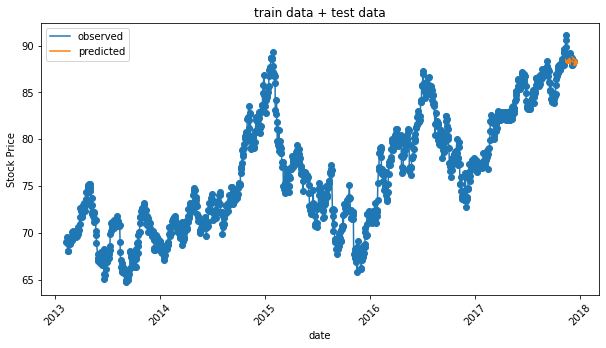

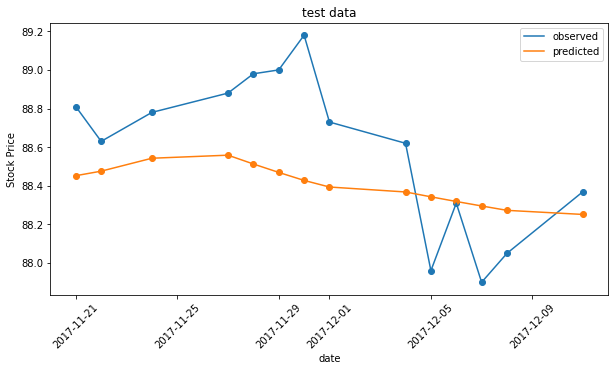

In [384]:
plt.figure(figsize=(10,5))
plt.plot(full_date, full_price, label="observed")
plt.scatter(full_date, full_price)
plt.plot(test_date, prediction_list, label="predicted")
plt.scatter(test_date, prediction_list)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("train data + test data")
plt.show()


plt.figure(figsize=(10,5))
plt.plot(test_date, test, label="observed")
plt.scatter(test_date, test)
plt.plot(test_date, prediction_list, label="predicted")
plt.scatter(test_date, prediction_list)
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.title("test data")
plt.legend()
plt.show()